In [44]:
import os
import pandas as pd
from glob import glob

dirname = '/workspace/paperassistant/backend/block_classifier/model'
fn_output = '/workspace/paperassistant/backend/block_classifier/all_outputs.xlsx'

TASKS = ['auto-structurize', 'predict_next_structure']
DATA_MODELS = ['ignore', 'replace', 'ignore-56', 'replace-56', 'ignore-5']
MODELS = ['bert', 'scibert', 'electra', 't5']
# batch_size
# lightning_logs
# version_

def make_result_stat():
	dirlist = glob(os.path.join(dirname, '*/*/*/*/*/version_*'))
	print('len(dirlist):', len(dirlist))

	tdf = pd.DataFrame()

	for dir in dirlist:
		ckpt = glob(os.path.join(dir, "*.ckpt"))
		if len(ckpt) == 0:
			print('ckpt not here in:', dir)
			continue
		elif len(ckpt) > 1:
			print('there are more than one ckpt in:', dir)
		ckpt_split = ckpt[0].split('/')[-1].split('-')
		#print('ckpt_split:', ckpt_split)
		epoch = ckpt_split[0].split('=')[1]
		val_loss = ckpt_split[1].split('=')[1]
		val_acc = ckpt_split[2].split('=')[1].split('.ckpt')[0]

		dir_split = dir.split('/')
		task = dir_split[-6]
		data_model = dir_split[-5]
		model = dir_split[-4]
		batch = dir_split[-3]
		
		fn_metrics = glob(os.path.join(dir, "*.csv"))[0]
		df = pd.read_csv(fn_metrics, sep='\t')
		#print(df['acc'])

		import yaml
		fn_hparams = glob(os.path.join(dir, "*.yaml"))[0]
		with open(fn_hparams) as f:
			hparams_yaml = yaml.load(f, Loader=yaml.FullLoader)
		lr = hparams_yaml['learning_rate']
		wd = hparams_yaml['weight_decay']
		adam_eps = hparams_yaml['adam_epsilon']
		num_class = hparams_yaml['num_class']
		with_sampler = hparams_yaml['with_sampler']

		df['task'] = [task]
		df['data_model'] = [data_model]
		df['num_class'] = [num_class]
		df['model'] = [model]
		df['batch'] = [batch]
		df['lr'] = [lr]
		df['with_sampler'] = [with_sampler]
		df['wd'] = [wd]
		df['adam_eps'] = [adam_eps]
		df['ckpt_epoch'] = [epoch]
		df['ckpt_val_loss'] = [val_loss]
		df['ckpt_val_acc'] = [val_acc]

		df = df[['task', 'data_model', 'num_class', 'model', 'batch', 
				 'acc', 'acc_top3', 'f1', 'f1_top3', 'recall', 'recall_top3',
				 'lr', 'with_sampler', 'wd', 'adam_eps',
				 'ckpt_epoch', 'ckpt_val_loss', 'ckpt_val_acc']]
		
		tdf = pd.concat([tdf, df], ignore_index=True)

	tdf.to_excel(fn_output, sheet_name='sheet1')
	print('excel was dumped at:', fn_output)
	

make_result_stat()

len(dirlist): 19
ckpt not here in: /workspace/paperassistant/backend/block_classifier/model/predict_next_structure/ignore-5/scibert/16/lightning_logs/version_1
excel was dumped at: /workspace/paperassistant/backend/block_classifier/all_outputs.xlsx


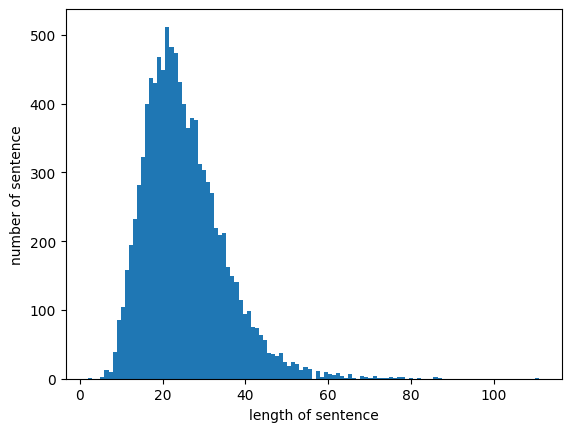

number of total samples: 10249
number of samples longer than 48: 255
max_seq_len: 111


In [33]:
### find max sequnce length

from nltk.tokenize import TreebankWordTokenizer
import matplotlib.pyplot as plt

tokenizer = TreebankWordTokenizer()

fn = '/workspace/paperassistant/backend/block_classifier/data/total_nosep.txt'

def get_len_dict(lines):
	max_len = 0
	len_dict = dict()

	for line in lines:
		sent = line.split('\t')[0]
		sent_tokens = tokenizer.tokenize(sent)
		len_tokens = len(sent_tokens)

		if len_tokens > max_len:
			max_len = len_tokens

		if len_dict.get(len_tokens) == None:
			len_dict[len_tokens] = 0
		len_dict[len_tokens] += 1
	
	return len_dict, max_len

def get_len_list(lines):
	max_len = 0
	len_list = list()

	for line in lines:
		sent = line.split('\t')[0]
		sent_tokens = tokenizer.tokenize(sent)
		len_tokens = len(sent_tokens)

		if len_tokens > max_len:
			max_len = len_tokens
		len_list.append(len_tokens)
	
	return len_list, max_len

with open(fn, 'r', encoding='utf-8') as rf:
	lines = rf.readlines()

#len_dict, max_len = get_len_dict(lines)
len_list, max_len = get_len_list(lines)
plt.hist(len_list, bins=max_len)
plt.ylabel('number of sentence')
plt.xlabel('length of sentence')
plt.show()

print('number of total samples:', len(len_list))
singular = 48
larger_than_singular = [l for l in len_list if l > singular]
print(f'number of samples longer than {singular}:', len(larger_than_singular))
print('max_seq_len:', max_len)